## Study propagation of correlation into a neural network

Our goal is to study how the correlations propagates from an input to the output of the neural network. This study can give us precious information about the behaviour of the accuracy for different sizes.

We want to consider each hidden output as a updated state $ z_{i,0} \rightarrow z_{i,t} $ where $t$ is the t-th block in the neural network.

We use a 2 channel U-net, for this reason each hidden state has two degrees of freedom $z^{\alpha}_{i,t}$ where $\alpha=\{0,1\}$.

In this case we study the evolution of $\langle z^{\alpha}_{l/2,t} z^{\beta}_{l/2+r,t} \rangle= C_{\alpha,\beta}(r,t)$ 

#### Imports

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn
from src.training.utils_analysis import test_models_unet
from scipy import stats
from typing import Tuple

# functions
def correlation_through_the_machine(z:torch.tensor,model:nn.Module,):
    x = torch.unsqueeze(z, dim=1)
    outputs=[]
    for i,block in enumerate(model.conv_downsample):
        x = block(x)
        outputs.append(x)
        if i==0:
            outputs_in=x.unsqueeze(0).detach().numpy()
        else:
            outputs_in=np.append(x.unsqueeze(0).detach().numpy(),outputs_in,axis=0)

    for i, block in enumerate(model.conv_upsample):
        if i == 0:
            x = block(x)
            outputs_out=x.unsqueeze(0).detach().numpy()
        else:
            x = x + outputs[model.n_conv_layers - 1 - i]
            x = block(x)
            if i<=len(model.conv_upsample)-2:
                outputs_out=np.append(x.unsqueeze(0).detach().numpy(),outputs_out,axis=0)
            if i==len(model.conv_upsample)-1:
                last_output=x.detach().numpy()
    f_dens = torch.squeeze(x)
    outputs=np.append(outputs_out,outputs_in,axis=0)
    return outputs,f_dens

def makes_the_fluctuations(outputs:np.ndarray,z:torch.tensor,channels:Tuple):
    x_0=np.append(z.detach().numpy().reshape(1,z.shape[0],z.shape[1]),outputs[:,:,channels[0],:],axis=0)
    x_1=np.append(z.detach().numpy().reshape(1,z.shape[0],z.shape[1]),outputs[:,:,channels[1],:],axis=0)
    mean_x=np.average(x_0)
    dx0=x_0-np.average(x_0,axis=1)[:,None,:]
    mean_x=np.average(x_1)
    dx1=x_1-np.average(x_1,axis=1)[:,None,:]
    return (dx0,dx1)

def covtt(dx0,dx1):
    return np.average(dx0[:,None,:,None,:]*dx1[None,:,:,:,None],axis=2)/(np.std(dx0,axis=1)[:,None,None,:]*np.std(dx1,axis=1)[None,:,:,None])

#### Data

In [9]:
ls=[16,24,32,64]

model=torch.load('model_rep/2nn_ising/h_5.44_15k_tester_neural_network_[2, 2, 2, 2, 2, 2, 2, 2]_hc_5_ks_1_ps_8_nconv_0_nblock',map_location='cpu')
model=torch.load('model_rep/2nn_ising/h_5.44_15k_nobias_[40, 40, 40, 40, 40]_hc_5_ks_1_ps_5_nconv_0_nblock',map_location='cpu')
model.eval()

#we study the training dataset because no overfitting occured and we need at least 1000 samples
z_numpy={}
f_numpy={}
z={}
h={}
for l in ls:
    data=np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_5.44_h_1000_n.npz')
    z_numpy[l]=data['density']
    f_numpy[l]=data['density_F']
    h_0=data['potential']
    z[l]=torch.tensor(z_numpy[l]).double()
    h[l]=torch.tensor(h_0).double()
    



#### Covariance a the starting point

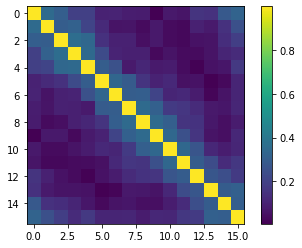

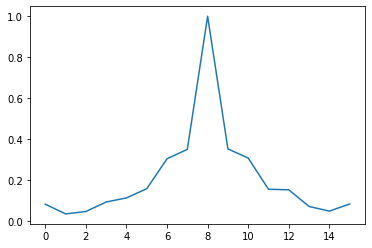

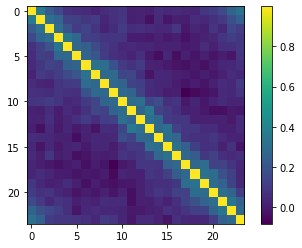

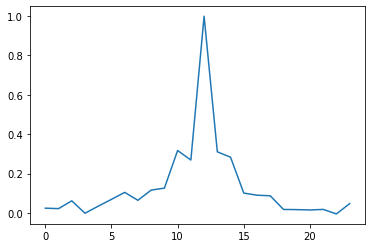

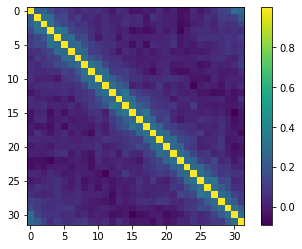

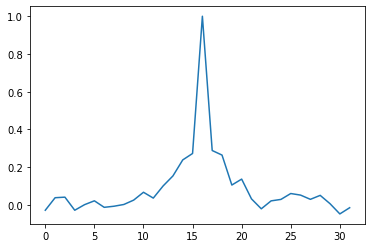

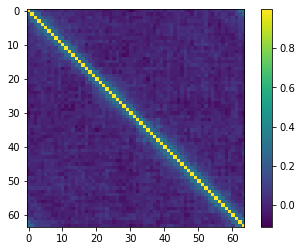

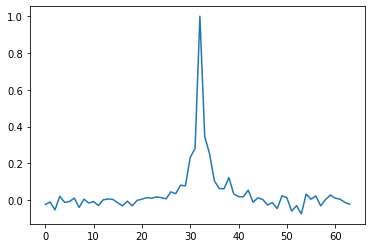

In [4]:
for l in ls:
    dz=z[l]-z[l].mean(0)[None,:]
    std=dz.std(0)
    cov=torch.mean(dz[:,None,:]*dz[:,:,None],dim=0)/(std[None,:]*std[:,None])

    plt.imshow(cov.detach().numpy())
    plt.colorbar()
    plt.show()

    plt.plot(cov[int(l/2)].detach().numpy())
    plt.show()

#### Evolution of the Covariance

In [10]:
f_dens={}
outputs_in={}
outputs_out={}
for l in ls:
    x = torch.unsqueeze(z[l], dim=1)
    outputs = []
    for i,block in enumerate(model.conv_downsample):
        x = block(x)
        outputs.append(x)
        if i==0:
            outputs_in[l]=x.unsqueeze(0).detach().numpy()
        else:
            outputs_in[l]=np.append(x.unsqueeze(0).detach().numpy(),outputs_in[l],axis=0)


    for i, block in enumerate(model.conv_upsample):
        if i == 0:
            x = block(x)
            outputs_out[l]=x.unsqueeze(0).detach().numpy()
        else:
            x = x + outputs[model.n_conv_layers - 1 - i]
            x = block(x)
            if i<=len(model.conv_upsample)-2:
                outputs_out[l]=np.append(x.unsqueeze(0).detach().numpy(),outputs_out[l],axis=0)
            if i==len(model.conv_upsample)-1:
                last_output=x.detach().numpy()
            
    f_dens[l] = torch.squeeze(x)


Compute the covariance at different times

In [11]:
outputs={}
for l in ls:
    outputs[l]=np.append(outputs_out[l],outputs_in[l],axis=0)
    



    

#### Covariance of the f density

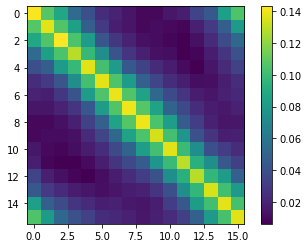

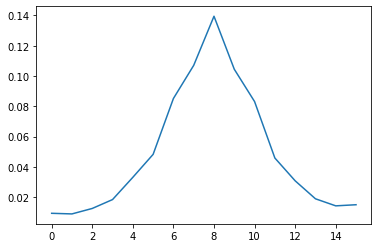

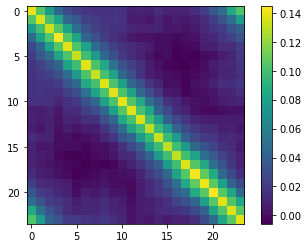

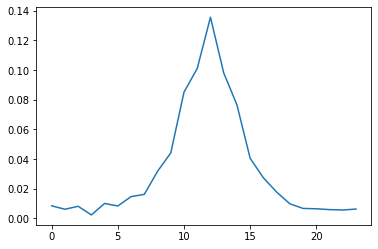

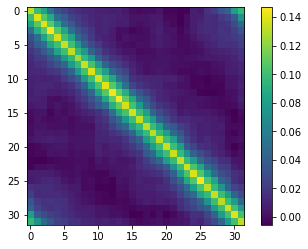

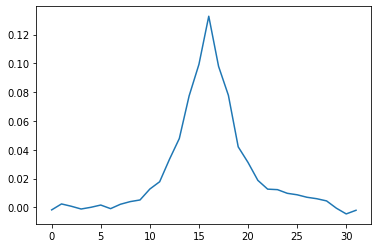

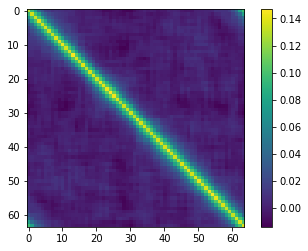

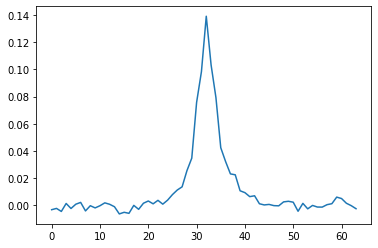

In [12]:
for l in ls:
    df=f_dens[l]-f_dens[l].mean(0)[None,:]
    mean_f=f_dens[l].mean()
    cov_f=torch.mean(df[:,None,:]*df[:,:,None],dim=0)/mean_f**2

    plt.imshow(cov_f.detach().numpy())
    plt.colorbar()
    plt.show()

    plt.plot(cov_f[int(l/2)].detach().numpy())
    plt.show()

#### Time-correlations

In [13]:
dx0={}
dx1={}
for l in ls:
    alpha=1
    x_0=np.append(z[l].detach().numpy().reshape(1,z[l].shape[0],z[l].shape[1]),outputs[l][:,:,0,:],axis=0)
    #x_0=np.append(x_0,f_dens.detach().numpy().reshape(1,f_dens.shape[0],f_dens.shape[1]),axis=0)
    #x_0=np.append(x_0,last_output.reshape(1,z.shape[0],z.shape[-1]),axis=0)
    #x_0=outputs

    x_1=np.append(z[l].detach().numpy().reshape(1,z[l].shape[0],z[l].shape[1]),outputs[l][:,:,1,:],axis=0)
    #x_1=np.append(x_0,f_dens.detach().numpy().reshape(1,f_dens.shape[0],f_dens.shape[1]),axis=0)
    #x_1=np.append(x_1,last_output.reshape(1,z.shape[0],z.shape[-1]),axis=0)
    #x_1=outputs


    print(x_0.shape)
    mean_x=np.average(x_0)
    dx0[l]=x_0-np.average(x_0,axis=1)[:,None,:]
    mean_x=np.average(x_1)
    dx1[l]=x_1-np.average(x_1,axis=1)[:,None,:]


def covtt(dx0,dx1):
    return np.average(dx0[:,None,:,None,:]*dx1[None,:,:,:,None],axis=2)/(np.std(dx0,axis=1)[:,None,None,:]*np.std(dx1,axis=1)[None,:,:,None])



(10, 1000, 16)
(10, 1000, 24)
(10, 1000, 32)
(10, 1000, 64)


#### Analysis of the information propagation

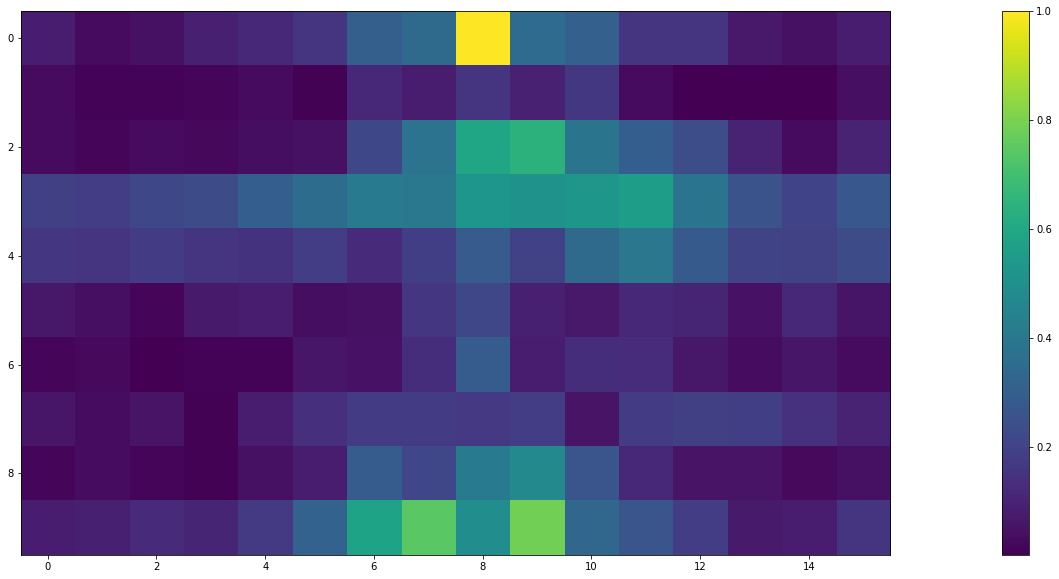

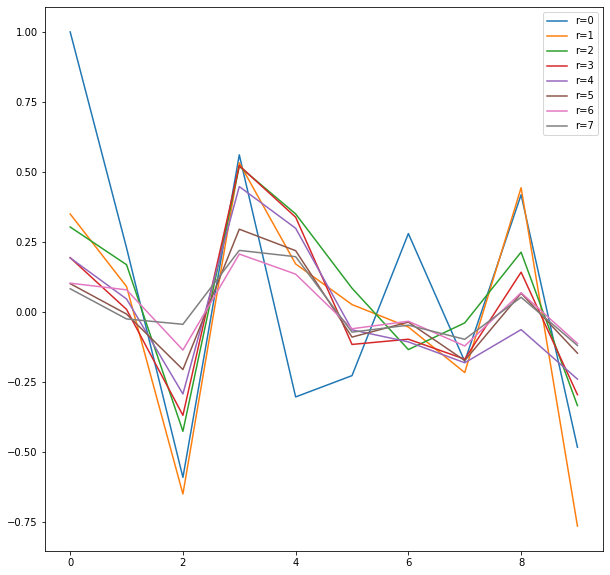

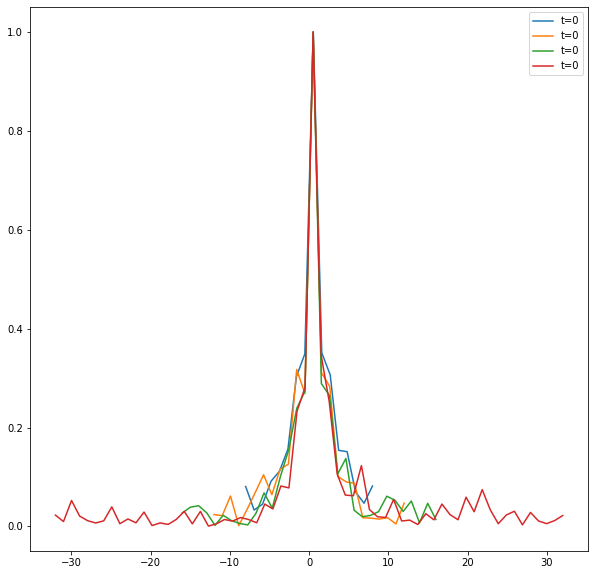

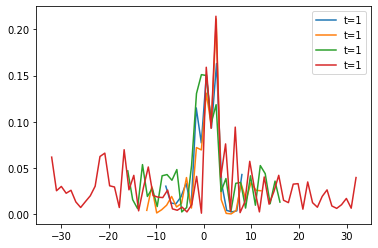

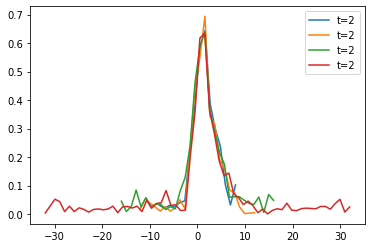

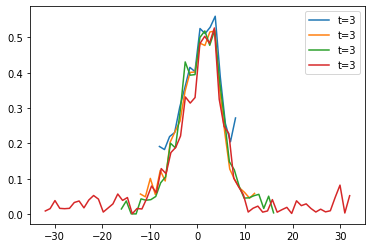

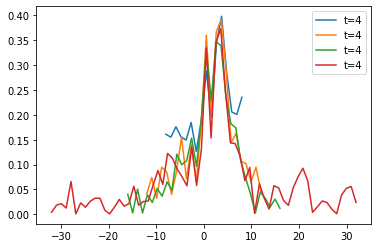

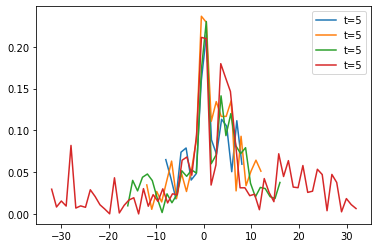

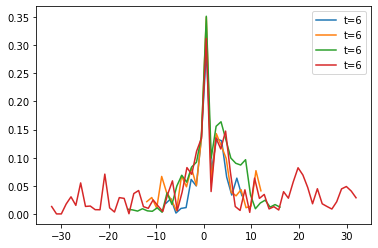

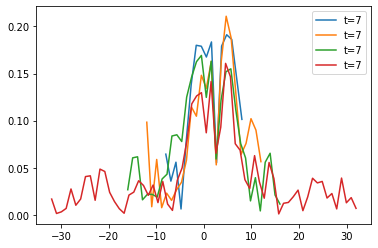

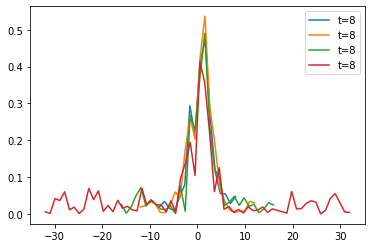

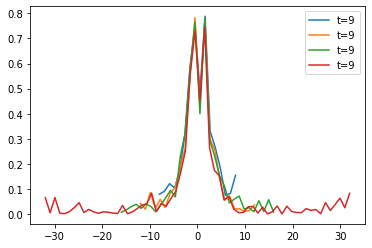

IndexError: index 10 is out of bounds for axis 1 with size 10

In [14]:
cov={}
for l in ls:
    cov[l]=covtt(dx0[l],dx0[l])

#time propagation of correlation in l/2
l=16
plt.figure(figsize=(40,10))
plt.imshow(np.abs(cov[l][0,:,int(l/2),:]))
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
for i in range(int(l/2)):
    plt.plot(cov[l][0,:,0,i],label=f'r={i}')
    
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for i in range(16):
    for l in ls:
        space=np.linspace(-l/2,l/2,l)
        plt.plot(space,np.abs(cov[l][0,i,int(l/2),:]),label=f't={i}')
    plt.legend()
    plt.show()

# correlation per time t
for t in range(16):
    plt.figure(figsize=(40,10))
    plt.imshow(np.abs(cov[l][0,t]))
    plt.title(f't={t}')
    plt.colorbar()
    plt.show()



#### Compute the correlation length

In [ ]:
from scipy import stats


jdx=np.arange(l)
xi=[]
for t in range(16):
    g=np.zeros((l,l))
    for i in range(l):
        #print(cov[0,t,jdx,(jdx+i)%l].shape)
        g[i,:]=(cov[0,t,jdx,(jdx+i)%l])
    plt.plot(np.average(np.abs(g[:int(l/2)]),axis=-1))
    plt.show()
    
        


    

In [ ]:
k=np.linspace(-np.pi/l,np.pi/l,l)
i=np.arange(l)
exp_k=np.exp(1j*(i[None,:,None]-i[:,None,None])*k[None,None,:])
cov_q=(1/l)*np.einsum('ijk,tyij->tyk',exp_k,cov)
cov_q=np.abs(cov_q)
a=np.log(cov_q[:,:,0])-np.log(cov_q[:,:,-1])
xi=(l/(2*np.pi))*np.sqrt(np.exp(a)-1)

plt.plot(xi[0])
plt.show()

#### Correlation and causation of the input-output

Data

In [15]:

ls=[16,32,48,64,80,96]
zs={}
fs={}
fs_ml={}
for l in ls:
    data=np.load(f'data/dataset_2nn/test_dataset_141122/test_unet_periodic_2nn_{l}_l_5.44_h_1000_n.npz')
    zs[l]=data['density']
    fs[l]=data['density_F']
    model=torch.load('model_rep/2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',map_location='cpu')
    model=torch.load('model_rep/2nn_ising/h_5.44_15k_nobias_[40, 40, 40, 40, 40]_hc_5_ks_1_ps_5_nconv_0_nblock',map_location='cpu')
    
    fs_ml[l]=model(torch.tensor(zs[l]).double()).detach().numpy()

Results

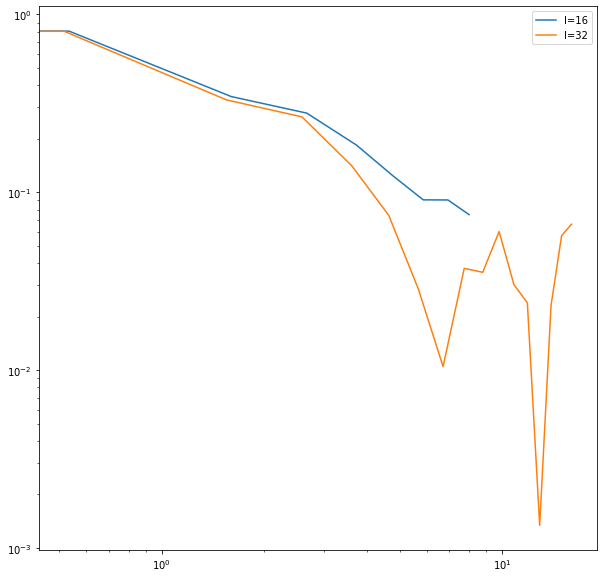

In [16]:
covs={}
gs={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,32]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
plt.loglog()
plt.show()

In [ ]:
covs_ml={}
gs_ml={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs_ml[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs_ml[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,32]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_ml[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
plt.loglog()
plt.show()

#### Covariance of the error $\delta f_i$ and the magnetization $z_i$

In [ ]:
covs_err={}
gs_err={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),np.abs(fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])-fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs_err[l]=cov


    c1=1
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs_err[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in ls:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_err[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Comparison between ML and exact covariances

In [ ]:
c1=0
c2=1
for l in ls:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_ml[l][c1,c2,int(l/2),:]),label=f'l={l}')
    plt.plot(space,np.abs(covs[l][c1,c2,int(l/2),:]),label=f'l={l}',color='red',linestyle='--')

    plt.legend()
#plt.loglog()
    plt.show()

In [ ]:
# print(gs[16].shape)
# plt.figure(figsize=(10,10))
# for l in ls:
#     plt.plot(np.abs(gs[l][0:int(l/2)]),label='exact')
#     plt.plot(np.abs(gs_ml[l][0:int(l/2)]),color='red',linewidth=3,linestyle='--',label='ml')
#     plt.loglog()
#     plt.xlabel(r'$r$',fontsize=20)
#     plt.ylabel(r'$g(r)$',fontsize=20)
#     plt.title(f'size={l}',fontsize=30)
#     plt.show()
    
for l in ls:
    plt.figure(figsize=(10,10))
    plt.imshow(np.abs(covs[l][c1,c2]-covs_ml[l][c1,c2]))
    plt.colorbar()
    plt.show()
    

#### Comparison of ${f_ml}$ and $f_{dens}$

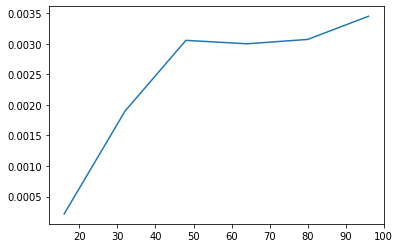

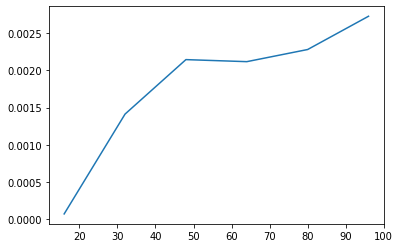

In [17]:
# for i in range(10):
#     plt.plot(fs[16][i])
#     plt.plot(fs_ml[16][i])
#     plt.show()

sample_df={}
err_f=[]
err_f_standard=[]
for l in ls:
    sample_df[l]=fs_ml[l].copy()-fs[l].copy()
    err_f.append(np.average(np.average(np.abs(sample_df[l]),axis=-1)))
    f_sum=np.average(fs[l],axis=-1)
    f_ml_sum=np.average(fs_ml[l],axis=-1)
    err_f_standard.append(np.average(np.abs(f_sum-f_ml_sum)))

plt.plot(ls,err_f)
plt.show()


plt.plot(ls,err_f_standard)
space=np.linspace(16,128,100)
#plt.loglog()
#plt.plot(space,0.5*space)
plt.show()

In [ ]:
for l in ls:
    df=np.abs(sample_df[l])
    df_wb=np.abs(sample_df[l][:,5:-5])
    for i in range(10):
        plt.plot(fs[l][i])
        plt.plot(fs_ml[l][i])
        plt.show()
    
    #plt.plot(np.average(df,axis=0))
    plt.plot(np.average(df_wb,axis=0))
    plt.show()
    
plt.figure(figsize=(10,10))
for l in ls:
    f_hist=fs[l].reshape(-1)
    plt.hist(f_hist,bins=100,label=f'l={l}',density=True,alpha=0.5)
plt.legend(fontsize=20)
plt.show()

    

In [ ]:
plt.figure(figsize=(10,10))
for l in ls:
    plt.hist(np.average(np.abs(sample_df[l]),axis=0),bins=100,label=f'l={l}',alpha=0.5)
    plt.legend(fontsize=20)
    plt.show()
    

#### Distribution of the error for each size

In [ ]:

for l in ls:
    plt.figure(figsize=(10,10))
    df=sample_df[l].reshape(-1)
    df_border=sample_df[l][:,-8:-1].reshape(-1)
    df_center=sample_df[l][:,8:-8].reshape(-1)
    plt.hist(df_border,bins=100,range=(-0.03,0.03),alpha=0.5,label=f'border l={l}',density=True,color='red')
    plt.hist(df_center,bins=100,range=(-0.03,0.03),alpha=0.5,label=f'center l={l}',density=True,color='blue')
    plt.legend(fontsize=20)
    print(np.average(df))
    #plt.loglog()
    plt.show()    


#### Correlation between output fluctuations and inputs

In [ ]:
covs={}
gs={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),np.abs(fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])-fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs[l]=cov


    c1=1
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs[l]=np.average(g,axis=0)


for l in ls:
    plt.figure(figsize=(10,10))
    plt.imshow(covs[l][c1,c2])
    plt.colorbar()
    plt.title(f'l={l}')
    plt.show()
    
for l in ls:
    plt.figure(figsize=(10,10))
    plt.plot(gs[l])
    plt.title(f'l={l}')
    plt.show()
    

## Study in the 1nn case

#### Imports

In [84]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn
from src.training.utils_analysis import test_models_unet

#### Data

In [90]:

ls=[16,24,32,64]
zs={}
fs={}
fs_ml={}
z={}
for l in ls:
    data=np.load(f'data/dataset_1nn/valid_unet_periodic_{l}_l_2.7_h_2000_n.npz')
    zs[l]=data['density']
    fs[l]=data['density_F']
    model=torch.load('model_rep/1nn_ising/h_2.7_15k_tester_neural_network_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',map_location='cpu')
    fs_ml[l]=model(torch.tensor(zs[l]).double()).detach().numpy()
    z[l]=torch.tensor(zs[l]).double()

#### Prediction accuracy of the nn

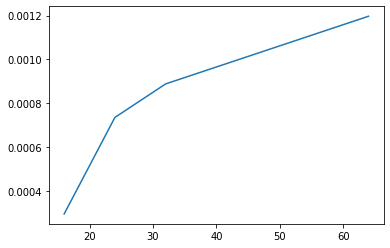

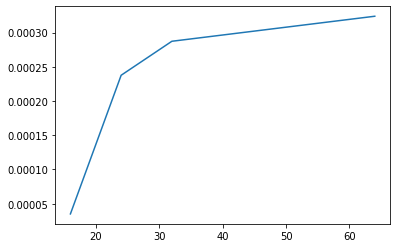

In [91]:
err_f=[]
err_f_standard=[]
for l in ls:
    err_f.append(np.average(np.average(np.abs(fs[l]-fs_ml[l]),axis=-1)/np.average(np.abs(fs[l]),axis=-1),axis=0))
    f_sum=np.average(fs[l],axis=-1)
    f_ml_sum=np.average(fs_ml[l],axis=-1)
    err_f_standard.append(np.average(np.abs(f_sum-f_ml_sum)))

plt.plot(ls,err_f)
plt.show()


plt.plot(ls,err_f_standard)
plt.show()

#### Evolution of the time correlation

In [89]:
f_dens={}
outputs_in={}
outputs_out={}
for l in ls:
    x = torch.unsqueeze(z[l], dim=1)
    outputs = []
    for i,block in enumerate(model.conv_downsample):
        x = block(x)
        outputs.append(x)
        if i==0:
            outputs_in[l]=x.unsqueeze(0).detach().numpy()
        else:
            outputs_in[l]=np.append(x.unsqueeze(0).detach().numpy(),outputs_in[l],axis=0)


    for i, block in enumerate(model.conv_upsample):
        if i == 0:
            x = block(x)
            outputs_out[l]=x.unsqueeze(0).detach().numpy()
        else:
            x = x + outputs[model.n_conv_layers - 1 - i]
            x = block(x)
            if i<=len(model.conv_upsample)-2:
                outputs_out[l]=np.append(x.unsqueeze(0).detach().numpy(),outputs_out[l],axis=0)
            if i==len(model.conv_upsample)-1:
                last_output=x.detach().numpy()
            
    f_dens[l] = torch.squeeze(x)
outputs={}
for l in ls:
    outputs[l]=np.append(outputs_out[l],outputs_in[l],axis=0)
    


KeyboardInterrupt: 

In [78]:
dx0={}
dx1={}
for l in ls:
    alpha=1
    x_0=np.append(z[l].detach().numpy().reshape(1,z[l].shape[0],z[l].shape[1]),outputs[l][:,:,0,:],axis=0)
    #x_0=np.append(x_0,f_dens.detach().numpy().reshape(1,f_dens.shape[0],f_dens.shape[1]),axis=0)
    #x_0=np.append(x_0,last_output.reshape(1,z.shape[0],z.shape[-1]),axis=0)
    #x_0=outputs

    x_1=np.append(z[l].detach().numpy().reshape(1,z[l].shape[0],z[l].shape[1]),outputs[l][:,:,1,:],axis=0)
    #x_1=np.append(x_0,f_dens.detach().numpy().reshape(1,f_dens.shape[0],f_dens.shape[1]),axis=0)
    #x_1=np.append(x_1,last_output.reshape(1,z.shape[0],z.shape[-1]),axis=0)
    #x_1=outputs


    print(x_0.shape)
    mean_x=np.average(x_0)
    dx0[l]=x_0-np.average(x_0,axis=1)[:,None,:]
    mean_x=np.average(x_1)
    dx1[l]=x_1-np.average(x_1,axis=1)[:,None,:]


def covtt(dx0,dx1):
    return np.average(dx0[:,None,:,None,:]*dx1[None,:,:,:,None],axis=2)/(np.std(dx0,axis=1)[:,None,None,:]*np.std(dx1,axis=1)[None,:,:,None])

(8, 2000, 16)
(8, 2000, 24)
(8, 2000, 32)
(8, 2000, 64)


#### Analysis of the information propagation

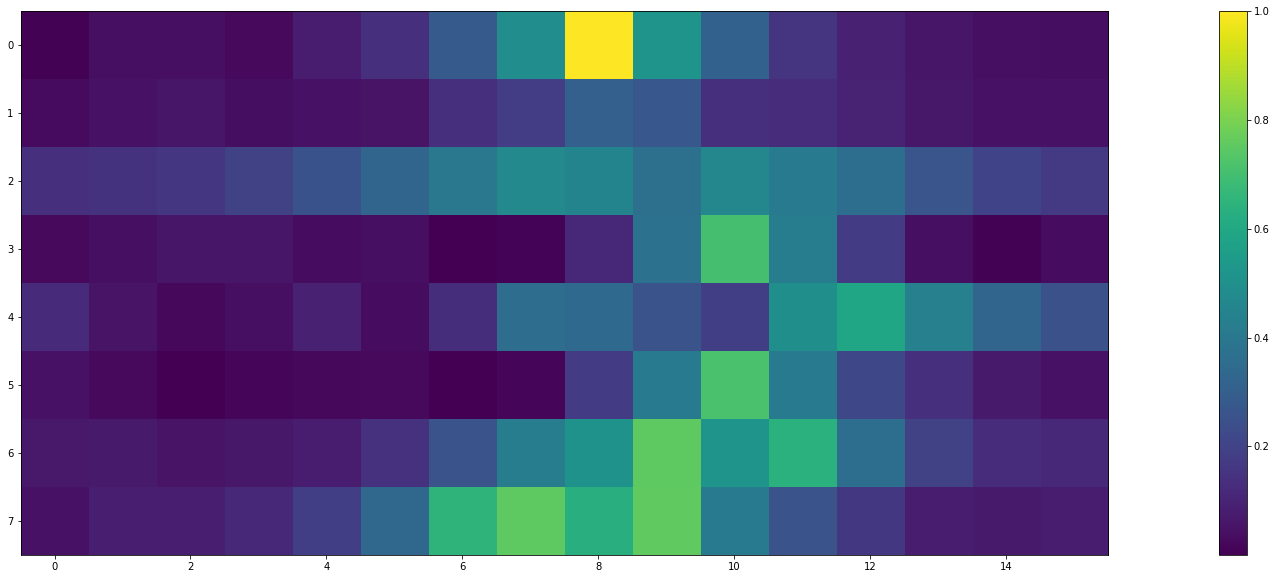

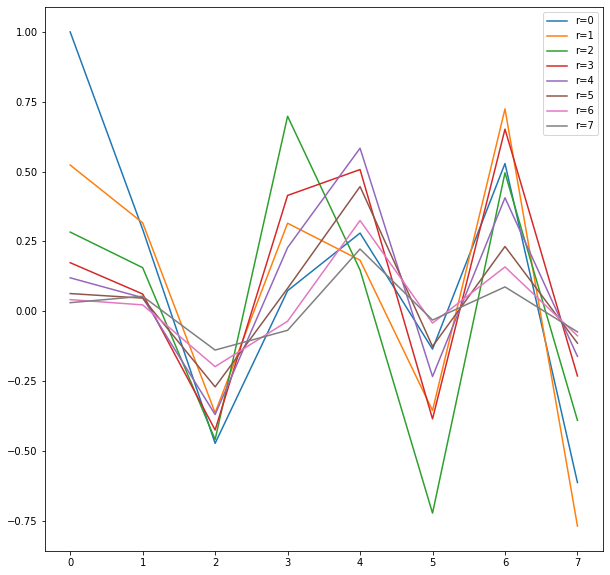

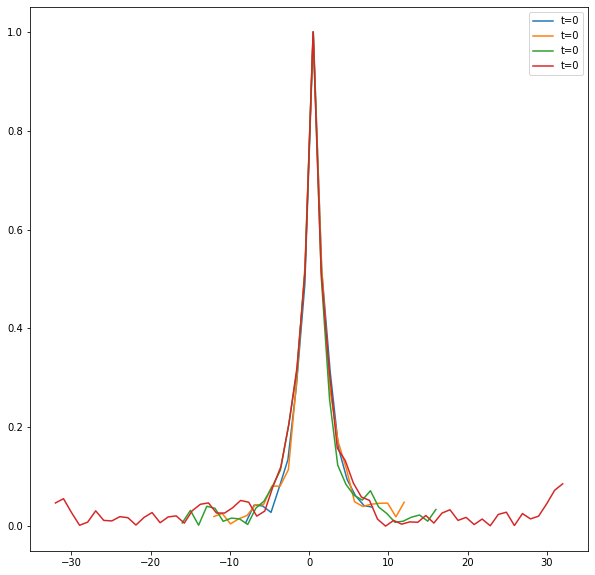

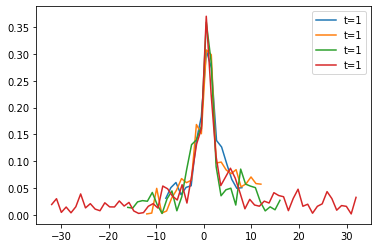

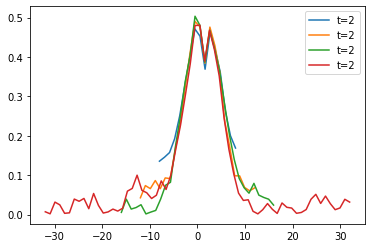

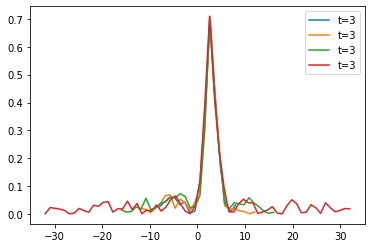

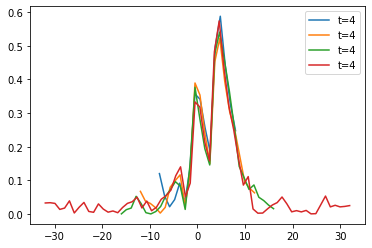

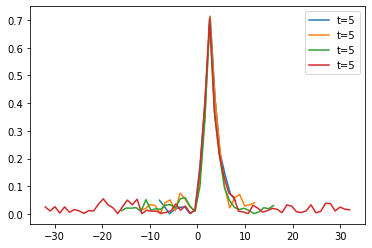

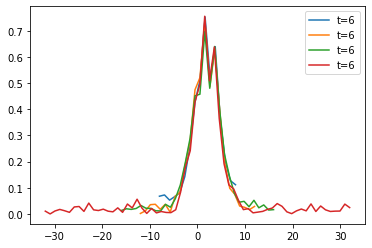

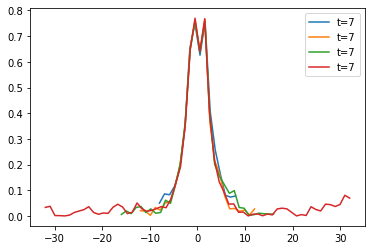

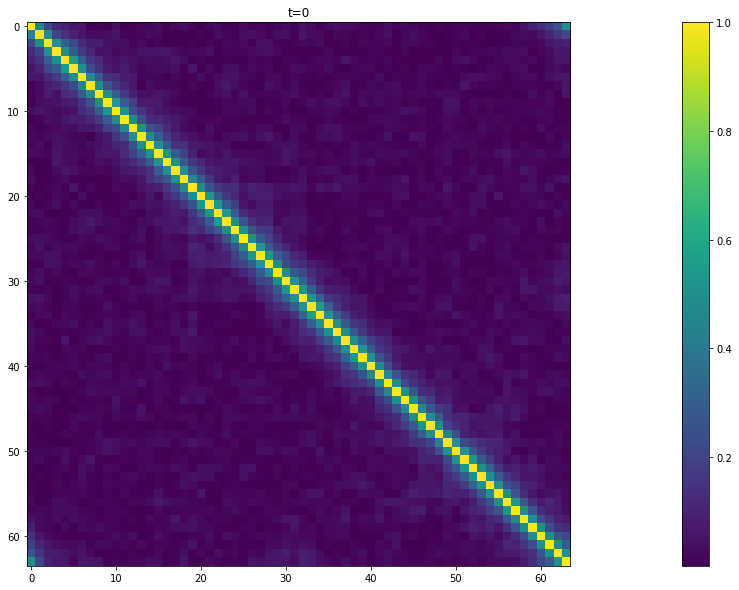

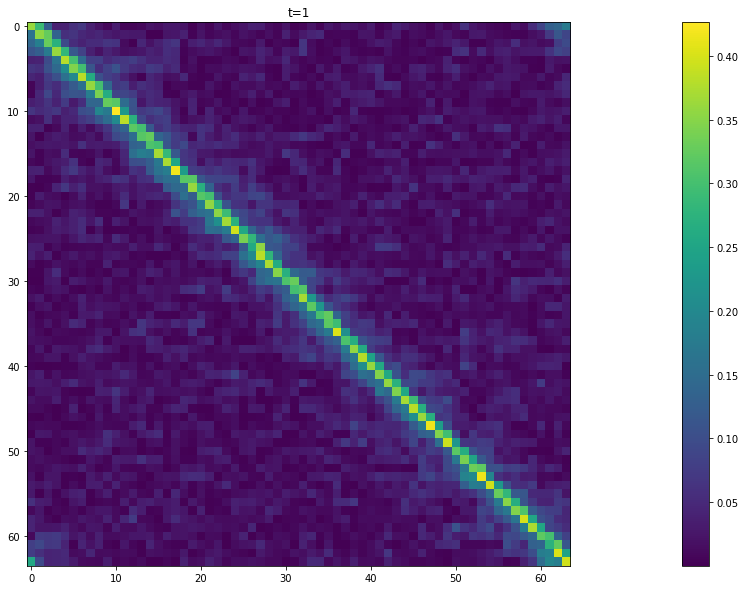

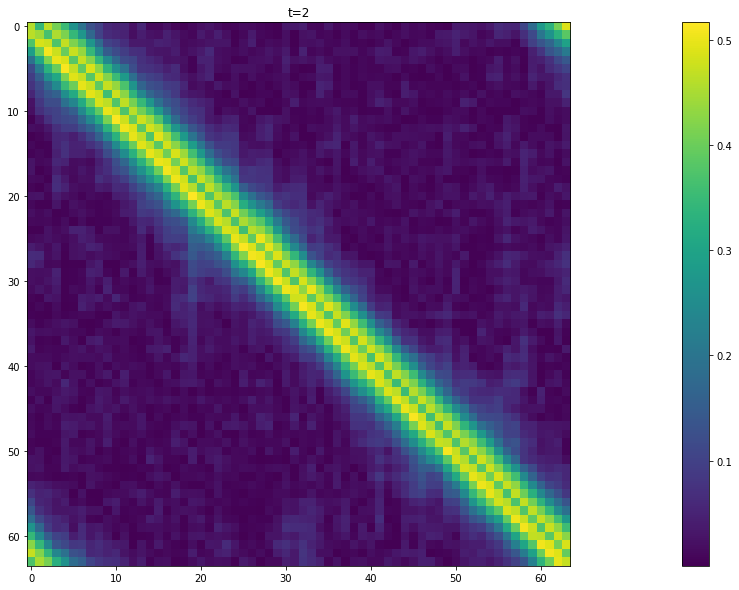

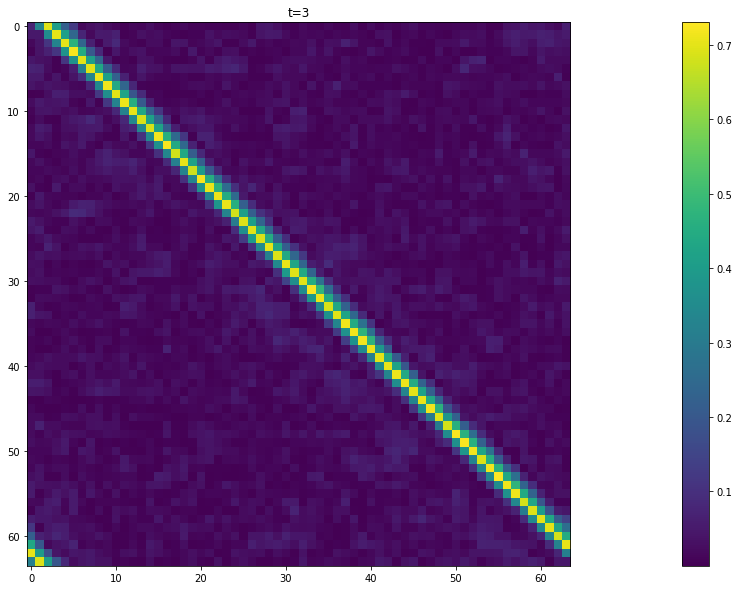

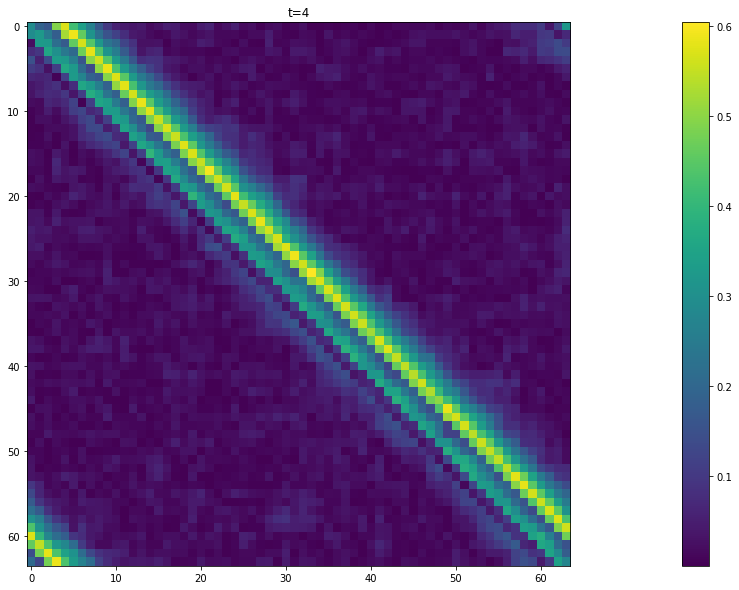

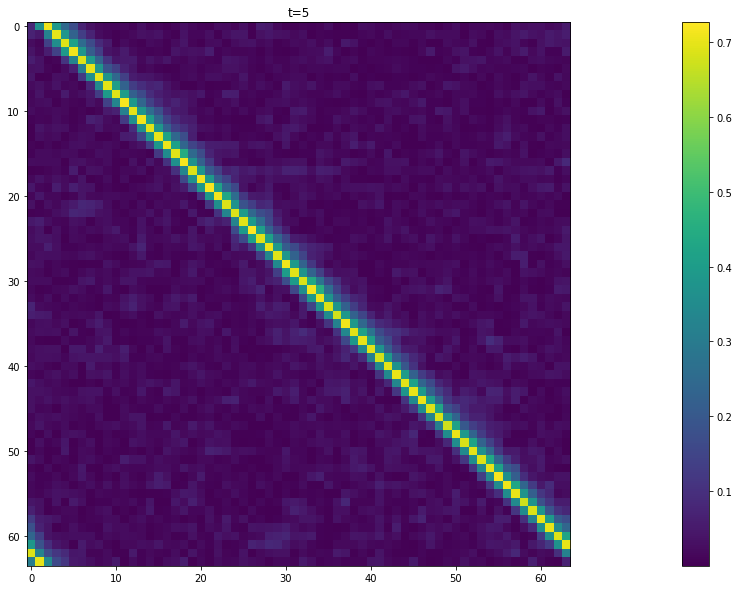

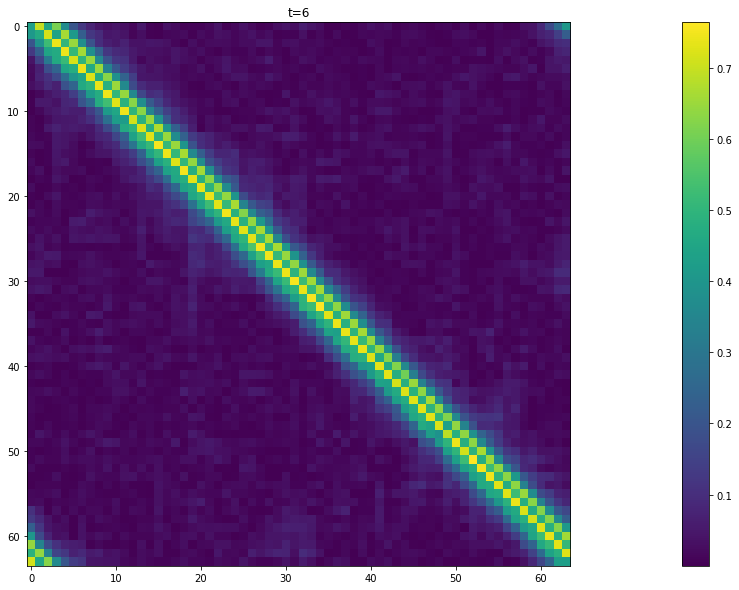

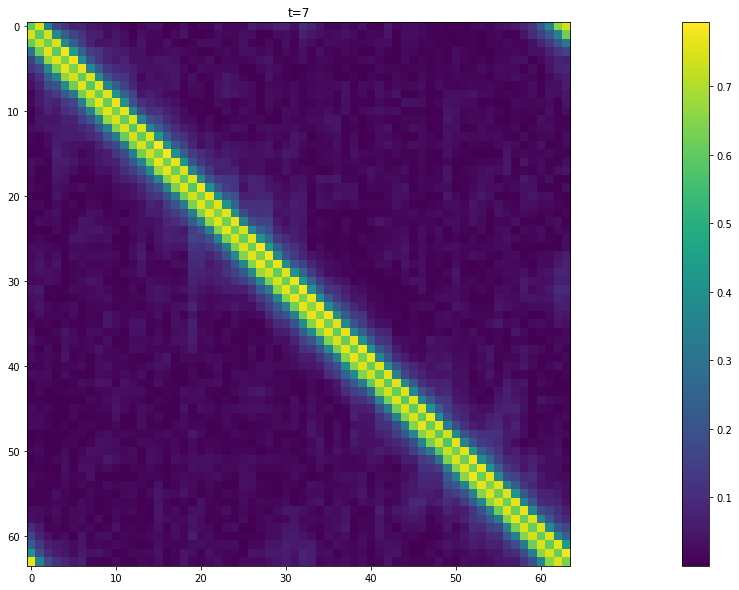

In [80]:
cov={}
for l in ls:
    cov[l]=covtt(dx0[l],dx0[l])

#time propagation of correlation in l/2
l=16
plt.figure(figsize=(40,10))
plt.imshow(np.abs(cov[l][0,:,int(l/2),:]))
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
for i in range(int(l/2)):
    plt.plot(cov[l][0,:,0,i],label=f'r={i}')
    
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for i in range(8):
    for l in ls:
        space=np.linspace(-l/2,l/2,l)
        plt.plot(space,np.abs(cov[l][0,i,int(l/2),:]),label=f't={i}')
    plt.legend()
    plt.show()

# correlation per time t
for t in range(8):
    plt.figure(figsize=(40,10))
    plt.imshow(np.abs(cov[l][0,t]))
    plt.title(f't={t}')
    plt.colorbar()
    plt.show()


#### Covariance analysis for $F_i$ and $z_i$

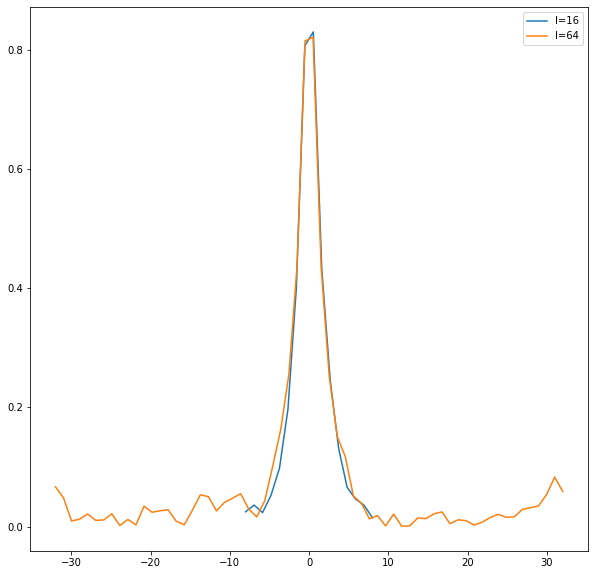

In [73]:
covs={}
gs={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,64]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Covariance analysis $F_{i,ML}$ and $z_i$

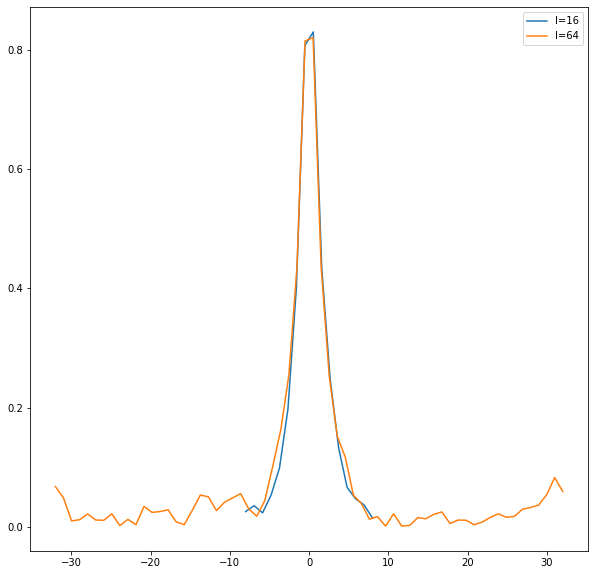

In [62]:
covs_ml={}
gs_ml={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs_ml[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs_ml[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,64]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_ml[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Covariance of $z_i$ and the error $\delta f_i$

In [ ]:
covs_err={}
gs_err={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),np.abs(fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])-fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs_err[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs_err[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [24,128]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_err[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Comparison between covariances

In [ ]:
plt.figure(figsize=(10,10))
for l in [24]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs[l][c1,c2,int(l/2),:]),label=f'l={l}')
    plt.plot(space,np.abs(covs_ml[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Comparison between ML and exact results

In [ ]:
print(gs[16].shape)
plt.figure(figsize=(10,10))
for l in ls:
    plt.plot(np.abs(gs[l][0:int(l/2)]),label='exact')
    plt.plot(np.abs(gs_ml[l][0:int(l/2)]),color='red',linewidth=3,linestyle='--',label='ml')
    plt.loglog()
    #plt.semilogy()
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$g(r)$',fontsize=20)
    plt.title(f'size={l}',fontsize=30)
    plt.show()
    
# for l in ls:
#     plt.figure(figsize=(10,10))
#     plt.imshow(np.abs(covs[l][c1,c2]-covs_ml[l][c1,c2]))
#     plt.colorbar()
#     plt.show()

#### Correlation of the error with the magnetization

In [ ]:
covs={}
gs={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),np.abs(fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])-fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs[l]=np.average(g,axis=0)


for l in ls:
    plt.figure(figsize=(10,10))
    plt.imshow(covs[l][c1,c2])
    plt.colorbar()
    plt.title(f'l={l}')
    plt.show()
    
for l in ls:
    plt.figure(figsize=(10,10))
    plt.plot(gs[l])
    plt.title(f'l={l}')
    plt.show()
    

## Comparison of the information spreading in both the 1nn and 2nn model

#### Data

In [3]:

ls=[16,32,64]
zs_1nn={}
zs_2nn={}
fs_2nn={}
fs_1nn={}

z_1nn={}
z_2nn={}
for l in ls:
    data=np.load(f'data/dataset_1nn/valid_unet_periodic_{l}_l_2.7_h_2000_n.npz')
    zs_1nn[l]=data['density']
    data=np.load(f'data/dataset_2nn/test_dataset_141122/test_unet_periodic_2nn_{l}_l_5.44_h_1000_n.npz')
    zs_2nn[l]=data['density']
    model_1nn=torch.load('model_rep/1nn_ising/h_2.7_15k_tester_neural_network_[2, 2, 2, 2, 2, 2, 2, 2]_hc_5_ks_1_ps_8_nconv_0_nblock',map_location='cpu')
    model_2nn=torch.load('model_rep/2nn_ising/h_5.44_15k_tester_neural_network_[2, 2, 2, 2, 2, 2, 2, 2]_hc_5_ks_1_ps_8_nconv_0_nblock',map_location='cpu')

    z_1nn[l]=torch.tensor(zs_1nn[l]).double()
    z_2nn[l]=torch.tensor(zs_2nn[l]).double()

#### Correlation analysis

In [6]:
cov_1nn={}
cov_2nn={}
for l in ls:
    outputs_1nn,_=correlation_through_the_machine(z_1nn[l],model_1nn)
    outputs_2nn,_=correlation_through_the_machine(z_2nn[l],model_2nn)
    dx0,dx1=makes_the_fluctuations(outputs_1nn,z_1nn[l],channels=[0,0])
    cov_1nn[l]=covtt(dx0,dx1)
    dx0,dx1=makes_the_fluctuations(outputs_2nn,z_2nn[l],channels=[0,0])
    cov_2nn[l]=covtt(dx0,dx1)

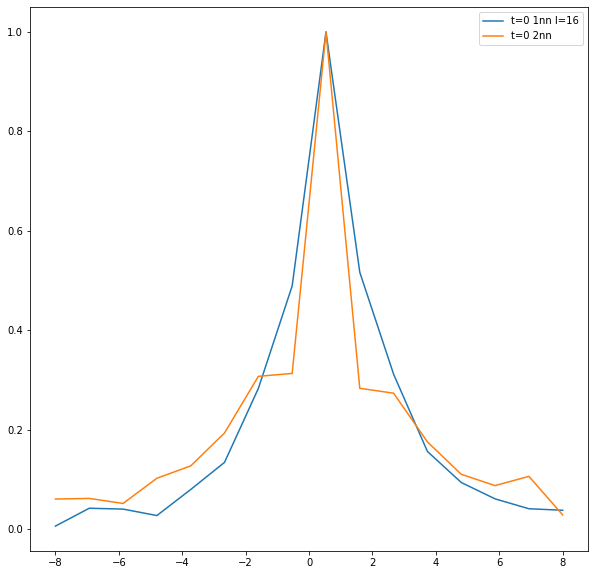

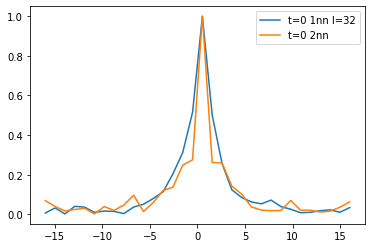

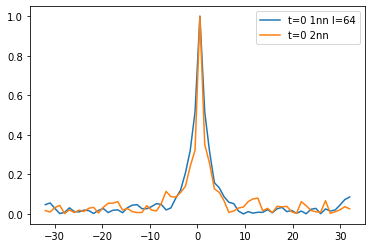

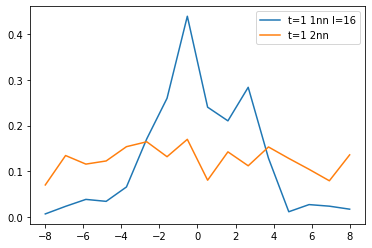

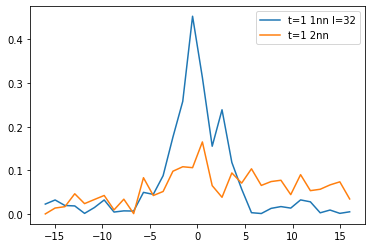

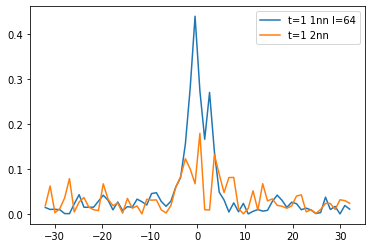

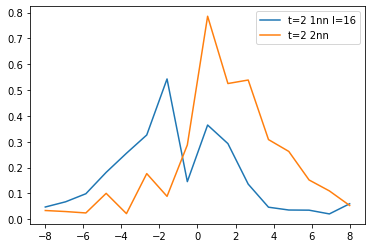

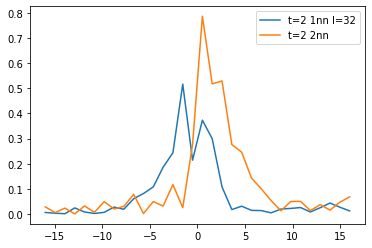

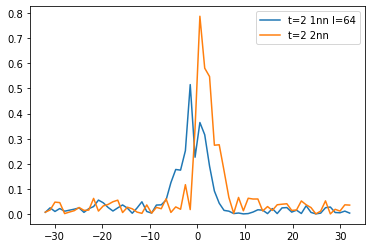

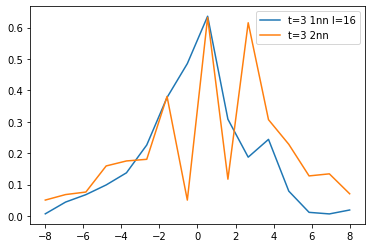

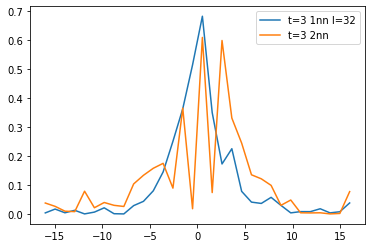

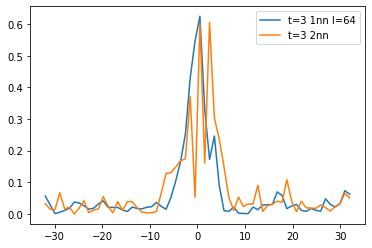

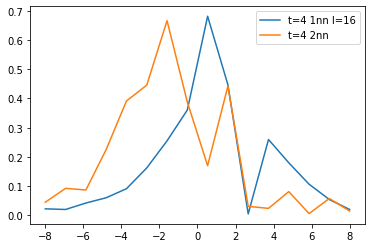

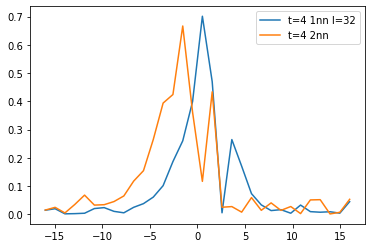

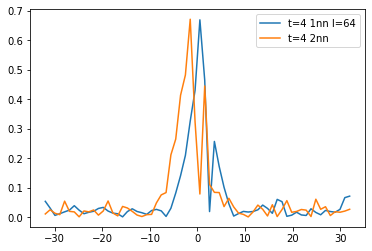

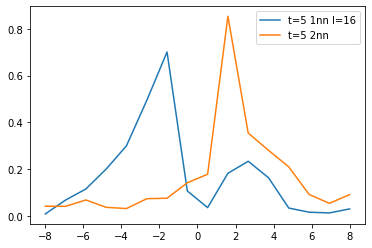

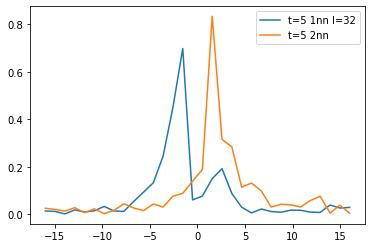

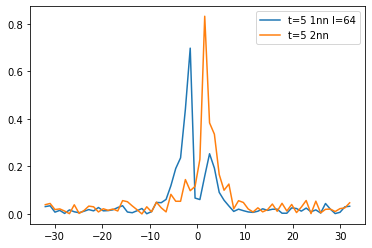

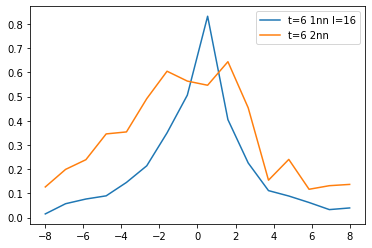

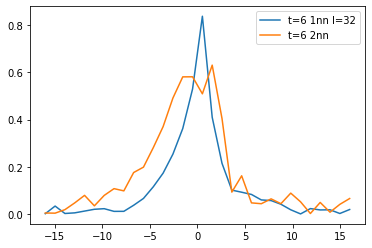

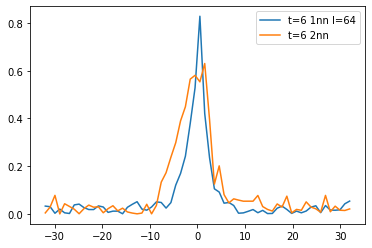

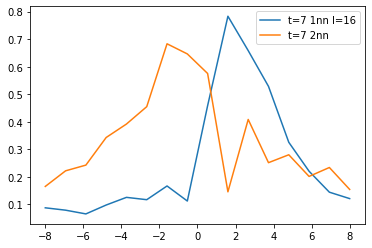

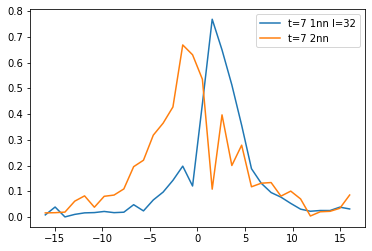

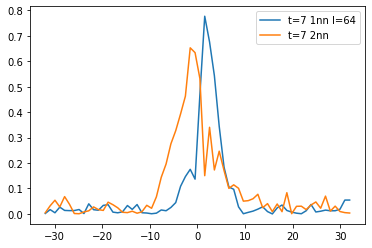

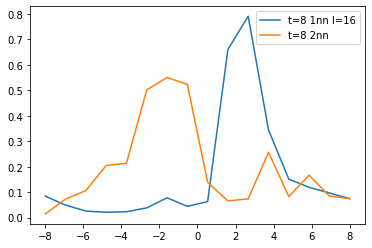

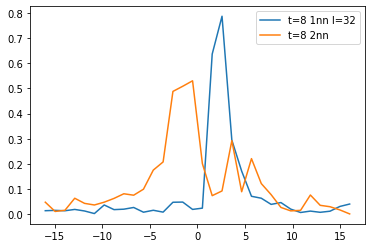

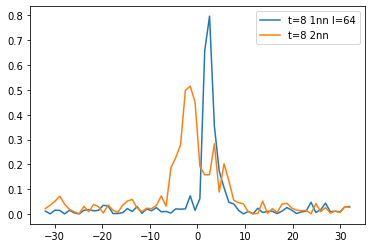

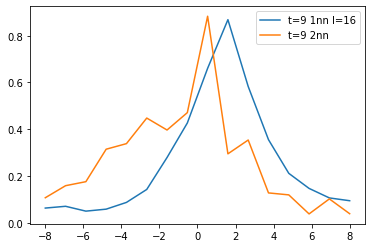

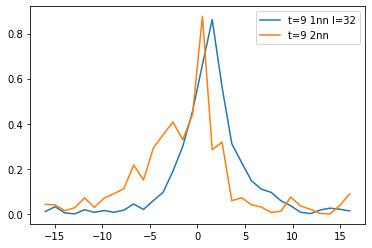

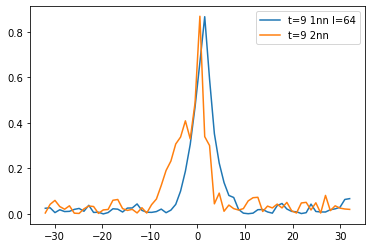

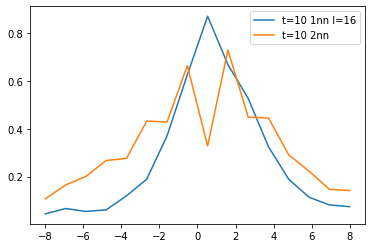

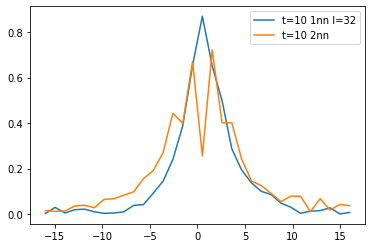

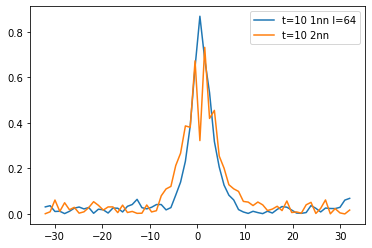

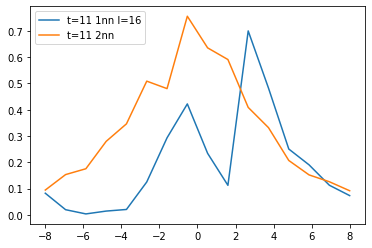

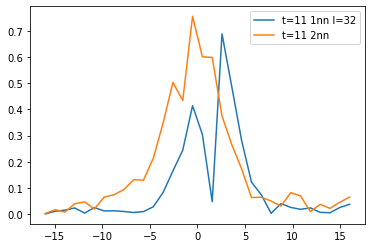

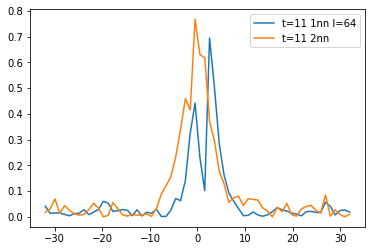

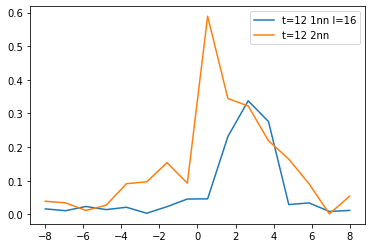

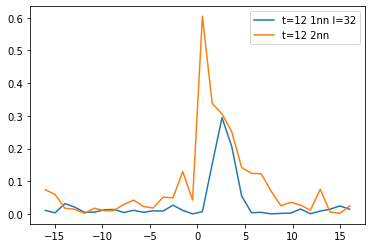

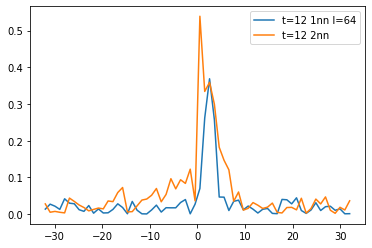

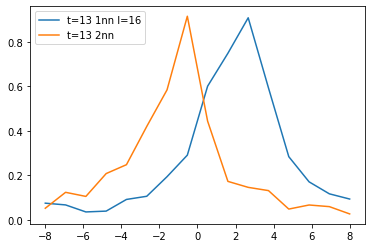

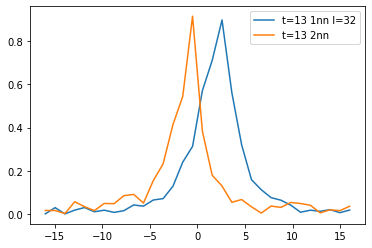

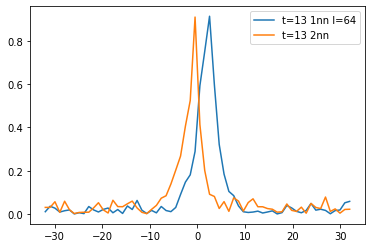

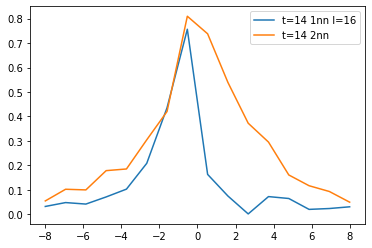

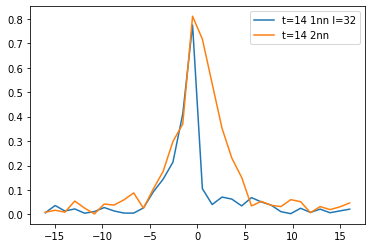

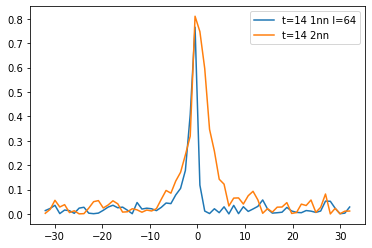

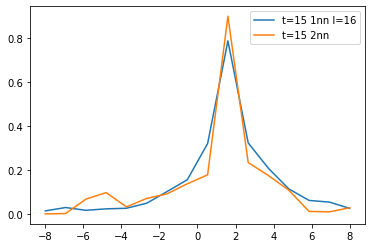

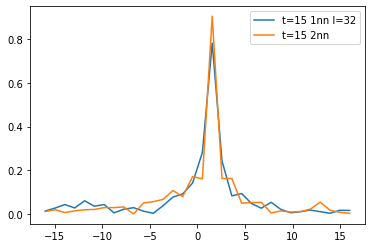

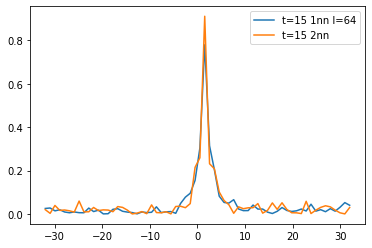

In [7]:




plt.figure(figsize=(10,10))
for i in range(16):
    for l in ls:
        space=np.linspace(-l/2,l/2,l)
        plt.plot(space,np.abs(cov_1nn[l][0,i,int(l/2),:]),label=f't={i} 1nn l={l}')
        plt.plot(space,np.abs(cov_2nn[l][0,i,int(l/2),:]),label=f't={i} 2nn')
        plt.legend()
        plt.show()
